Visualizing Data using t-SNE: https://jmlr.csail.mit.edu/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

Copyright (C) 2023, Zhao Bingqiang, All Rights Reserved

Email: zbqherb@163.com

2023-07-10

# Load Libs

In [1]:
import cv2
import random
from tqdm import tqdm
from PIL import Image

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torchvision.models.feature_extraction import create_feature_extractor

from sklearn.manifold import TSNE
import umap
import umap.plot
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## Image data preprocessing

In [2]:
# COVID-19 CT
train_transform = transforms.Compose([transforms.RandomResizedCrop(512),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))])

test_transform = transforms.Compose([transforms.Resize(1000),
                                     transforms.CenterCrop(512),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

## Load `trained model`

In [3]:
model = torch.load('checkpoint/best-0.971.pth')
model = model.eval().to(device)

# Extract output results of the middle layer  as semantic features and Calculate semantic features of single image
model_trunc = create_feature_extractor(model, return_nodes={'avgpool': 'semantic_feature'})

## Load `test_dataset prediction results.csv` and Calculate semantic features of each image in the test_dataset

In [4]:
df = pd.read_csv('table/test_dataset prediction results.csv')
encoding_array = []
img_path_list = []

for img_path in tqdm(df['Data Path']):
    img_path_list.append(img_path)
    img_pil = Image.open(img_path).convert('RGB')
    input_img = test_transform(img_pil).unsqueeze(0).to(device) 
    # forward prediction to obtain the output of the avgpool layer
    feature = model_trunc(input_img)['semantic_feature'].squeeze().detach().cpu().numpy() 
    encoding_array.append(feature)
    
encoding_array = np.array(encoding_array)
np.save('table/test_dataset semantic features.npy', encoding_array)
encoding_array.shape

100%|██████████████████████████████████████████████████████████████████████████████| 3419/3419 [01:02<00:00, 54.84it/s]


(3419, 512)

# Visualization setting

In [5]:
marker_list = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', '*', 'h', 'H', '+', 'x', 'X', 'D', 'd', '|', '_', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
class_list = np.unique(df['Label Name'])
n_class = len(class_list) # test_dataset ID number
palette = sns.hls_palette(n_class) 

# Randomly shuffle the color list and dot type list
random.seed(1234)
random.shuffle(marker_list)
random.shuffle(palette)

## t-SNE 2D visualization

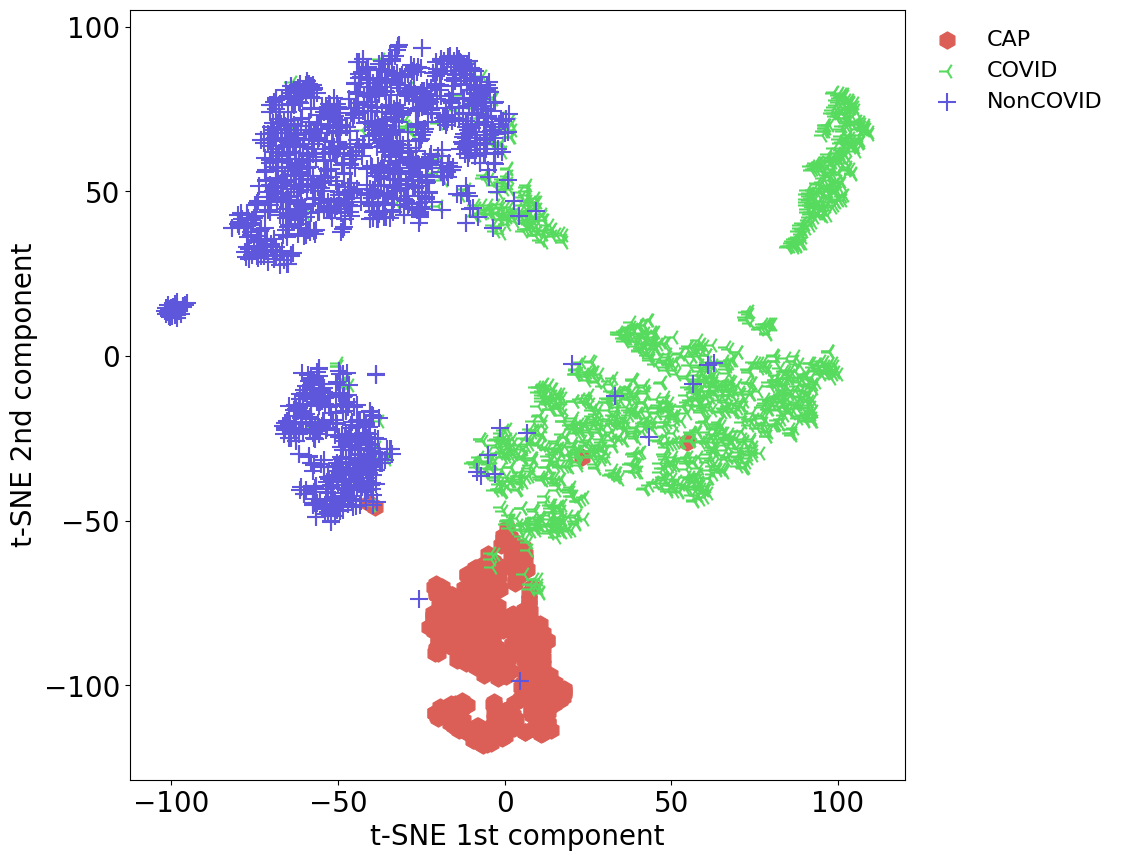

In [6]:
tsne = TSNE(n_components = 2, n_iter = 20000)
X_tsne_2d = tsne.fit_transform(encoding_array)

show_feature = 'Label Name'
plt.rcParams['font.size'] = 20
plt.figure(figsize = (15, 15))
for idx, image in enumerate(class_list): # Scanning each class

    color = palette[idx]
    marker = marker_list[idx%len(marker_list)]

    # Find the index number of all images labeled as the current class
    indices = np.where(df[show_feature] == image)
    plt.scatter(X_tsne_2d[indices, 0], X_tsne_2d[indices, 1], color = color, marker = marker, label = image, s = 150)

plt.legend(fontsize = 16, markerscale = 1, bbox_to_anchor = (1, 1), frameon = False)
plt.xlabel('t-SNE 1st component', fontsize = 20)
plt.ylabel('t-SNE 2nd component', fontsize = 20)
plt.savefig('figure/t-SNE.tif', dpi = 300, bbox_inches = 'tight') 

## t-SNE `plotply` 2D interactive visualization 

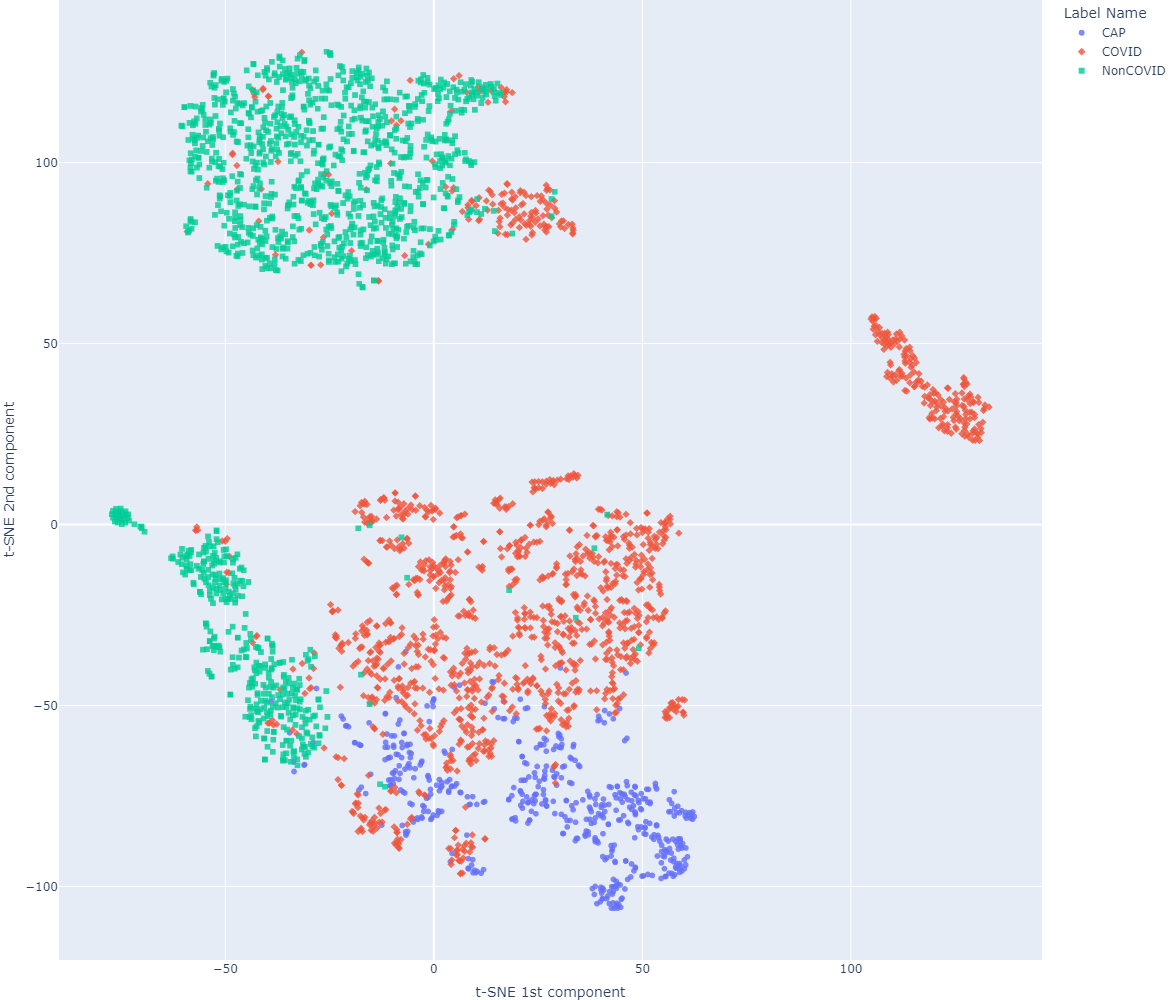

In [8]:
df_2d = pd.DataFrame()
df_2d['t-SNE 1st component'] = list(X_tsne_2d[:, 0].squeeze())
df_2d['t-SNE 2nd component'] = list(X_tsne_2d[:, 1].squeeze())
df_2d['Label Name'] = df['Label Name']
df_2d['Predicted Class'] = df['top-1 Predicted Name']
df_2d['Data Path'] = df['Data Path']
df_2d.to_csv('table/t-SNE-2D.csv', index = False)

fig = px.scatter(df_2d, 
                 x = 't-SNE 1st component', 
                 y = 't-SNE 2nd component',
                 color = show_feature, 
                 labels = show_feature,
                 symbol = show_feature, 
                 hover_name = 'Data Path',
                 opacity = 0.8,
                 width = 1000, 
                 height = 1000
                )
# Layout set
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))
fig.show()
fig.write_html('figure/t-SNE 2D.html')

## t-SNE 3D Visualization

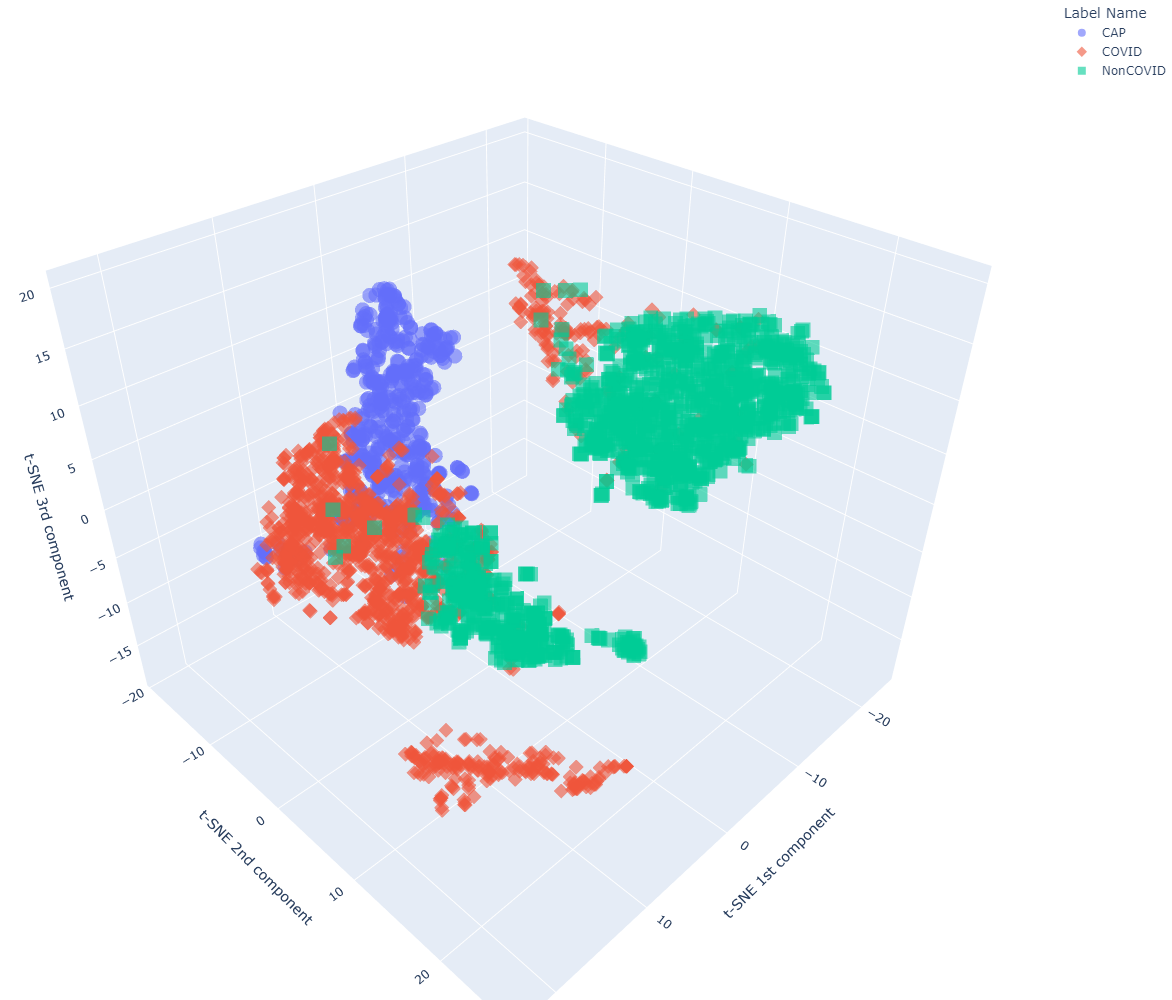

In [9]:
tsne = TSNE(n_components = 3, n_iter = 20000)
X_tsne_3d = tsne.fit_transform(encoding_array)

show_feature = 'Label Name'

df_3d = pd.DataFrame()
df_3d['t-SNE 1st component'] = list(X_tsne_3d[:, 0].squeeze())
df_3d['t-SNE 2nd component'] = list(X_tsne_3d[:, 1].squeeze())
df_3d['t-SNE 3rd component'] = list(X_tsne_3d[:, 2].squeeze())
df_3d['Label Name'] = df['Label Name']
df_3d['Predicted Class'] = df['top-1 Predicted Name']
df_3d['Data Path'] = df['Data Path']
df_3d.to_csv('table/t-SNE-3D.csv', index = False)

fig = px.scatter_3d(df_3d, 
                    x = 't-SNE 1st component', 
                    y = 't-SNE 2nd component', 
                    z = 't-SNE 3rd component',
                    color = show_feature, 
                    labels = show_feature,
                    symbol = show_feature, 
                    hover_name = 'Data Path',
                    opacity = 0.6,
                    width = 1000, 
                    height = 1000)

fig.update_layout(margin=dict(l = 0, r = 0, b = 0, t = 0))
fig.show()
fig.write_html('figure/t-SNE 3D.html')